In [1]:
import torch
import torch.nn as nn

In [3]:
from tqdm.auto import tqdm

/Users/matiasmolinolo/anaconda3/envs/iag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
class NADE(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(NADE, self).__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size

        self.W_in = nn.Parameter(torch.randn(input_dim, hidden_size))
        self.b_in = nn.Parameter(torch.randn(input_dim))

        self.W_hidden = nn.Parameter(torch.randn(hidden_size, input_dim))
        self.b_hidden = nn.Parameter(torch.randn(hidden_size))

    def forward(self, x):
        batch_size = x.shape[0]
        num_features = x.shape[1]

        a = self.b_hidden
        
        probs = torch.zeros(batch_size, num_features)

        for i in range(num_features):
            h = torch.sigmoid(a).reshape(-1, self.hidden_size)
            probs[:, i] = torch.sigmoid(self.W_in[i, :] @ h.T + self.b_in[i])
            a = torch.matmul(self.W_hidden[:, i].reshape(-1, 1), x[:, i].reshape(1, -1)).reshape(-1, self.hidden_size) + a
        
        return probs
    
    def sample(self, device):
        with torch.no_grad():
            preds = torch.zeros(1, self.input_dim).to(device)
            for i in tqdm(range(self.input_dim)):
                p = self.forward(preds)
                preds[:, i] = torch.bernoulli(p[:, i])
            
            return torch.reshape(preds, (28, 28))

In [21]:
in_size = 784
hidden_size = 500

In [22]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x >= 0.5).float(),
])

original_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
original_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

filter_digit = 3

filtered_train_dataset = [item for item in original_train_dataset if item[1] == filter_digit]
filtered_test_dataset = [item for item in original_test_dataset if item[1] == filter_digit]

filtered_dataset = filtered_train_dataset + filtered_test_dataset

data_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [25]:
device = torch.device('cpu')

In [26]:
nade = NADE(in_size, hidden_size).to(device)

In [27]:
criterion = nn.BCELoss().to(device)
optim = optim.Adam(nade.parameters(), lr=0.001)

In [28]:
epochs = 3
for epoch in range(epochs):
    for batch, (data, _) in tqdm(enumerate(data_loader)):
        data = data.view(in_size, -1)

        optim.zero_grad()
        output = nade(data.to(device))
        loss = criterion(output.to(device), data.to(device))
        loss.backward()
        optim.step()

        if batch % 100 == 0:
            print(f'Epoch: {epoch + 1}, Batch: {batch}, Loss: {loss.item()}')

2it [00:00,  5.61it/s]

Epoch: 1, Batch: 0, Loss: 10.172370910644531


102it [00:14,  8.23it/s]

Epoch: 1, Batch: 100, Loss: 1.2683634757995605


112it [00:16,  6.99it/s]
2it [00:00,  7.94it/s]

Epoch: 2, Batch: 0, Loss: 1.250388741493225


101it [00:12,  8.28it/s]

Epoch: 2, Batch: 100, Loss: 1.134709358215332


112it [00:14,  7.99it/s]
2it [00:00,  6.08it/s]

Epoch: 3, Batch: 0, Loss: 1.1261060237884521


102it [00:13,  8.60it/s]

Epoch: 3, Batch: 100, Loss: 1.0388706922531128


112it [00:14,  7.60it/s]


In [29]:
torch.save(nade, 'nade.pt')

In [30]:
img = nade.sample(device)

100%|██████████| 784/784 [00:40<00:00, 19.38it/s]


In [31]:
import matplotlib.pyplot as plt

In [32]:
def show_sample(img):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

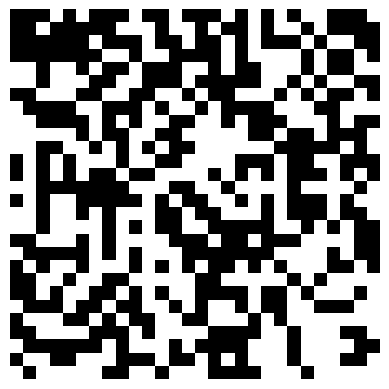

In [33]:
show_sample(img)